In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import f1_score
import os

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
data_dir = '/Users/hannahschieber/GitHub/deep_seg/data/Simpsons/simpsons_dataset/'
num_workers = 1

In [5]:
def get_train_and_test_dataloaders(data_dir, test_pct, batch_size):
  # first define some transforms 
    num_workers=1
    if torch.cuda.is_available():
        pin_memory = True
        num_workers=1
    resize = transforms.Resize((255,255))
    to_tensor = transforms.ToTensor()
    normalise = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    horizontal_flip = transforms.RandomHorizontalFlip(p=0.3)
    random_crop = transforms.RandomCrop(90)

  # now compose these for the train and test datasets
    train_transforms = transforms.Compose([resize,
                                         horizontal_flip,
                                         #random_crop,
                                          to_tensor, 
                                          normalise])
  
    test_transforms = transforms.Compose([resize,
                                        to_tensor, 
                                        normalise])
  # get the dataset
    train_dataset = datasets.ImageFolder(data_dir, transform = train_transforms)
    test_dataset = datasets.ImageFolder(data_dir, transform = test_transforms)
  # get class to idx mapping 
    class_to_idx = train_dataset.class_to_idx
  # invert the class map (i.e. idx to class)
    idx_to_class = {v: k for k, v in class_to_idx.items()}
  # get number of photos 
    len_train = len(train_dataset)
    indicies = list(range(len_train))
    split = int(np.floor(test_pct * len_train))

    np.random.shuffle(indicies)

    train_idx, test_idx = indicies[split:], indicies[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                             batch_size=batch_size, 
                                             sampler=train_sampler,
                                             num_workers=num_workers, 
                                             )
  
    test_loader = torch.utils.data.DataLoader(test_dataset, 
                                             batch_size=batch_size, 
                                             sampler=test_sampler,
                                             num_workers=num_workers, 
                                             )

    return train_loader, test_loader, class_to_idx, idx_to_class

In [6]:
train_loader, test_loader, class_to_idx, idx_to_class = get_train_and_test_dataloaders(data_dir = data_dir, test_pct = 0.2, batch_size = 32)

edna_krabappel,ned_flanders,simpsons_dataset,simpsons_dataset,ned_flanders,simpsons_dataset,simpsons_dataset,simpsons_dataset,simpsons_dataset,simpsons_dataset


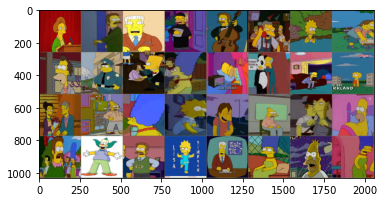

In [7]:
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
# get some random training images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

print(','.join('%5s' % idx_to_class[labels[j].item()] for j in range(10)))

In [8]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/hannahschieber/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [9]:
no_features = model.fc.in_features
model.fc = nn.Linear(no_features, 43)

In [10]:
criterion = nn.CrossEntropyLoss()

In [11]:
lr = 3.76E-02
optimiser = optim.SGD(model.parameters(), lr = lr)

In [12]:
def fit(model: nn.Module, 
        criterion, 
        optimiser, 
        epochs: int,
        lr: float,
        train_dataloader: 
        DataLoader, 
        test_dataloader: DataLoader, 
        audit_train: int = None):
  """
  Def to fit model, will automatically use GPU if avliable
  """
  
  def evaluate_performance(model: nn.Module, 
                           test_dataloader: DataLoader, 
                           test_acc: list, 
                           test_loss: list):
    batch_loss = 0
    total_test=0
    correct_test=0

    with torch.no_grad():

        model.eval()

        for data in (test_dataloader):
            images_test, labels_test = data
            if torch.cuda.is_available():
              images_test, labels_test = inputs.cuda(), labels.cuda()
            outputs_test = model(images_test)
            loss_test = criterion(outputs_test, labels_test)
            batch_loss += loss_test.item()
            _,predictions_test = torch.max(outputs_test, dim=1)
            correct_test += torch.sum(predictions_test==labels_test).item()
            total_test += labels_test.size(0)

        test_acc.append(100 * correct_test/total_test)
        test_loss.append(batch_loss/len(test_dataloader))
        
        print("\nValidation Loss: {:.4f} | Validation Accuracy: {:.4f}"
        .format(np.mean(test_loss),
                                    100 * correct_test/total_test))

  test_loss = []
  test_acc = []
  train_loss = []
  train_acc = []
  total_batches = len(train_loader)
  epoch_no = 0

  lr_sched = optim.lr_scheduler.OneCycleLR(optimizer = optimiser,
                                         max_lr = lr,
                                         epochs = epochs, 
                                         steps_per_epoch = 100,
                                         anneal_strategy = "cos", 
                                         cycle_momentum = True, 
                                         )

  if audit_train is None:
    audit_train = int(total_batches / 5)

  if torch.cuda.is_available():
    print("Using GPU")
    # move model to GPU
    model.cuda()

  for epoch in range(epochs):

      running_loss = 0.0
      correct = 0
      total= 0
      batch_no = 0

      for data in tqdm(train_loader):
          inputs, labels = data
          if torch.cuda.is_available():
            # move features and labels to GPU
            inputs, labels = inputs.cuda(), labels.cuda()
          # zero the parameter gradients
          optimiser.zero_grad()
          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimiser.step()
          running_loss += loss.item()

          _,predictions = torch.max(outputs, dim=1)
          correct += torch.sum(predictions==labels).item()
          total += labels.size(0)

          if batch_no % audit_train == 0:
              print ('\nEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                    .format(epoch + 1, epochs , batch_no, total_batches, loss.item()))
          batch_no += 1
      train_acc.append(100 * correct / total)
      train_loss.append(running_loss/total_batches)

      evaluate_performance(model = model, test_dataloader = test_dataloader, test_acc = test_acc, test_loss = test_loss)

In [13]:
fit(model = model, criterion = criterion, lr = lr, optimiser = optimiser, epochs = 1, train_dataloader = train_loader, test_dataloader = test_loader, )

  0%|          | 1/1047 [00:06<2:00:27,  6.91s/it]


Epoch [1/1], Step [0/1047], Loss: 4.0258


 20%|██        | 210/1047 [20:33<1:33:06,  6.67s/it]


Epoch [1/1], Step [209/1047], Loss: 1.4375


 40%|████      | 419/1047 [39:39<52:26,  5.01s/it]  


Epoch [1/1], Step [418/1047], Loss: 1.1652


 60%|█████▉    | 628/1047 [57:22<34:32,  4.95s/it]  


Epoch [1/1], Step [627/1047], Loss: 0.9715


 80%|███████▉  | 837/1047 [1:23:18<17:52,  5.11s/it]    


Epoch [1/1], Step [836/1047], Loss: 1.0868


100%|█████████▉| 1046/1047 [1:40:26<00:04,  4.86s/it]


Epoch [1/1], Step [1045/1047], Loss: 1.0019


100%|██████████| 1047/1047 [1:40:34<00:00,  5.76s/it]



Validation Loss: 1.0959 | Validation Accuracy: 47.2710


In [14]:
def get_sample_dataloader(data_dir, batch_size):

  if torch.cuda.is_available():
    pin_memory = True
    num_workers=1

  # first define some transforms 
  resize = transforms.Resize((255,255))
  to_tensor = transforms.ToTensor()
  normalise = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


  
  sample_transforms = transforms.Compose([resize,
                                        to_tensor, 
                                        normalise])
  # get the dataset
  sample_dataset = datasets.ImageFolder(data_dir, transform = sample_transforms)
  
  sample_loader = torch.utils.data.DataLoader(sample_dataset, 
                                             batch_size=batch_size
                                              )

  return sample_loader

In [15]:
sample_dataloader = get_sample_dataloader('/Users/hannahschieber/GitHub/deep_seg/data/Simpsons/kaggle_simpson_testset/', batch_size = 19)

In [ ]:
for data in sample_dataloader:
  images, labels = data
  if torch.cuda.is_available():
    images = images.cuda()
  outputs = model(images)
  _,predictions = torch.max(outputs, dim=1)
  for i in range(len(predictions)):
    print(idx_to_class[predictions[i].item()])
  images = images.cpu()
  imshow(torchvision.utils.make_grid(images))

abraham_grampa_simpson
simpsons_dataset
simpsons_dataset
simpsons_dataset
abraham_grampa_simpson
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
abraham_grampa_simpson
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
abraham_grampa_simpson
simpsons_dataset
simpsons_dataset
simpsons_dataset
abraham_grampa_simpson
abraham_grampa_simpson
simpsons_dataset
simpsons_dataset
simpsons_dataset
abraham_grampa_simpson
simpsons_dataset
abraham_grampa_simpson
simpsons_dataset
simpsons_dataset
simpsons_dataset
abraham_grampa_simpson
simpsons_dataset
abraham_grampa_simpson
simpsons_dataset
simpsons_dataset
simpsons_dataset
apu_nahasapeemapetilon
apu_nahasapeemapetilon
apu_nahasapeemapetilon
apu_nahasapeemapetilon
apu_nahasapeemapetilon
apu_nahas

simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
lenny_leonard
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
lenny_leonard
simpsons_dataset
simpsons_dataset
lenny_leonard
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
lenny_leonard
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_

simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset
simpsons_dataset


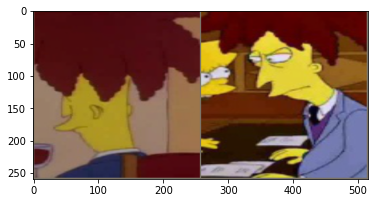